## О ноутбуке
-------------
Дата создания - Июнь 2022.

**Исследуем данные для определения дальнейших шагов:**
- обработки;
- нормализации;
- кодирования.

**Немного вводных по поводу предстоящей задачи:**
- Сердечно-сосудистые заболевания (ССЗ) занимают первое место среди причин смерти во всем мире, ежегодно унося жизни 17,9 млн. человек, что составляет 31% всех смертей в мире. Четыре из пяти случаев смерти от ССЗ связаны с инфарктами и инсультами, причем треть этих смертей происходит преждевременно у людей моложе 70 лет. Сердечная недостаточность - распространенное явление, вызванное ССЗ, и данный набор данных содержит 11 признаков, которые могут быть использованы для прогнозирования возможного заболевания сердца.
- Люди с сердечно-сосудистыми заболеваниями или с высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия или уже установленное заболевание) нуждаются в раннем выявлении и лечении, и в этом случае модель машинного обучения может оказать большую помощь.

**Признаки датасета:**
- Age : возраст пациента [лет]
- Sex : пол пациента [M: мужской, F: женский]
- ChestPainType : тип боли в груди [TA: типичная стенокардия, ATA: атипичная стенокардия, NAP: неангинальная боль, ASY: бессимптомная].
- RestingBP : артериальное давление в покое [мм рт. ст.]
- Cholesterol : холестерин сыворотки крови [мм/дл]
- FastingBS : сахар крови натощак [1: если FastingBS > 120 мг/дл, 0: иначе]
-RestingECG : результаты электрокардиограммы покоя [Normal: норма, ST: наличие аномалии ST-T (инверсии Т-волны и/или повышение или понижение ST > 0,05 мВ), LVH: наличие вероятной или определенной гипертрофии левого желудочка по критериям Эстеса].
- MaxHR : максимальная достигнутая частота сердечных сокращений [Числовое значение от 60 до 202]
- ExerciseAngina : стенокардия, вызванная физической нагрузкой [Y: Yes, N: No]
- Oldpeak : oldpeak = ST [Числовое значение, измеренное в депрессии]
- ST_Slope : наклон сегмента ST пиковой нагрузки [Up: upsloping, Flat: flat, Down: downsloping].
- HeartDisease : выходной класс [1: сердечно-сосудистые заболевания, 0: норма]

**TO-DO:**
- [x] Провести преобработку данных
- [] Нормализовать данные
- [] Заэнкодить фичи
- [] Проверить разные модели
- [] Реализовать сервис при помощи streamlit

------------

### Код для анализа

In [1]:
import sys

sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from src.preproccesing import dummy_encode, standard_norm
from src.finding_models import model, model_evaluation

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/home/nfrvnikita/miocard/data/heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


- Посмотрим на средние значения признаков для больных и не больных людей.

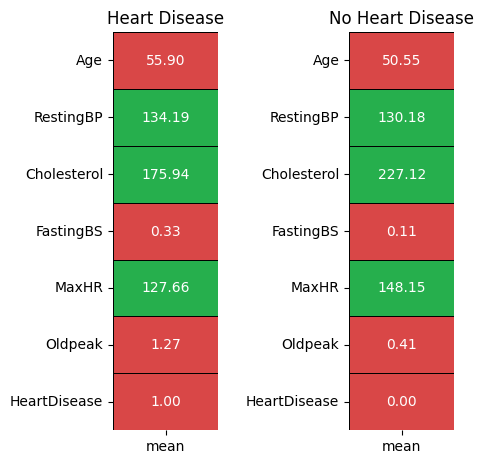

In [5]:
yes = data[data['HeartDisease'] == 1].describe().T
no = data[data['HeartDisease'] == 0].describe().T
colors = ['#D94747','#26AF4D']

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(5,5))
plt.subplot(1,2,1)
sns.heatmap(yes[['mean']], annot=True, cmap=colors, linewidths=0.5, linecolor='black', cbar=False, fmt='.2f')
plt.title('Heart Disease')

plt.subplot(1,2,2)
sns.heatmap(no[['mean']], annot=True, cmap=colors, linewidths=0.5, linecolor='black', cbar=False, fmt='.2f')
plt.title('No Heart Disease')

fig.tight_layout(pad=2)

- Исследуем категориальные и числовые признаки

In [6]:
list_columns = list(data.columns)

num_features = []
cat_features = []

for col in list_columns:
    if len(data[col].unique()) > 6:
        num_features.append(col)
    else:
        cat_features.append(col)

In [7]:
print(f'Числовые признаки: {num_features}')
print(f'Категориальные признаки: {cat_features}')

Числовые признаки: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Категориальные признаки: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']


- Категориальные

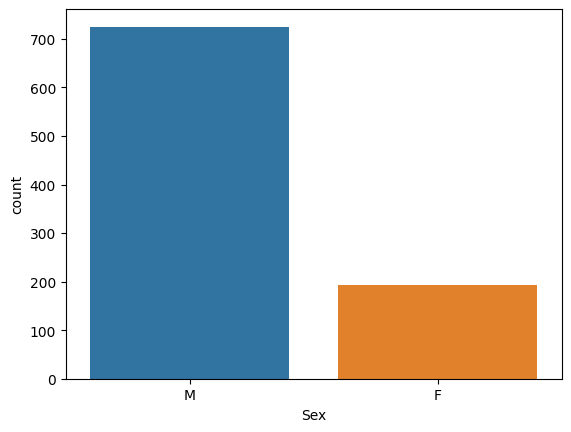

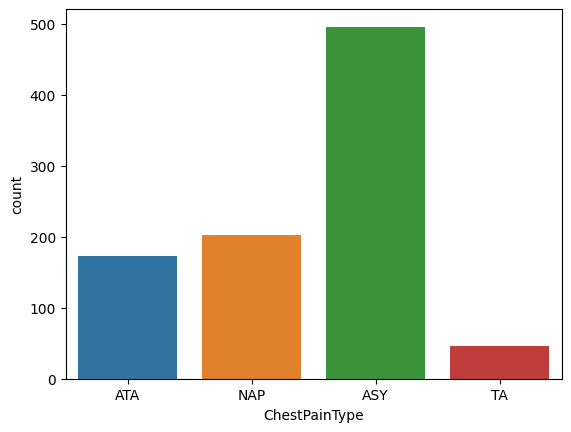

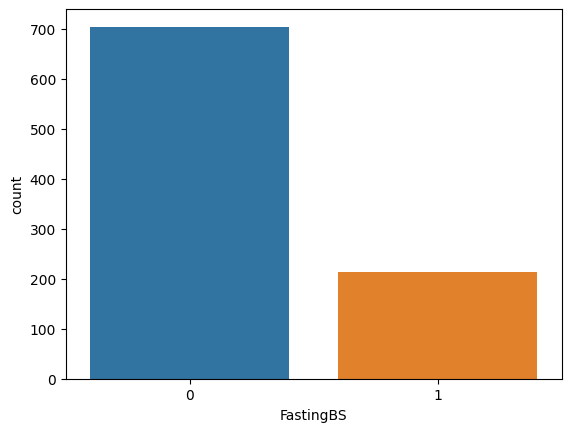

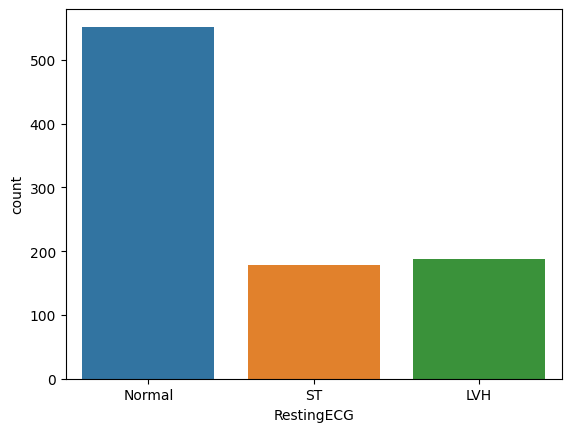

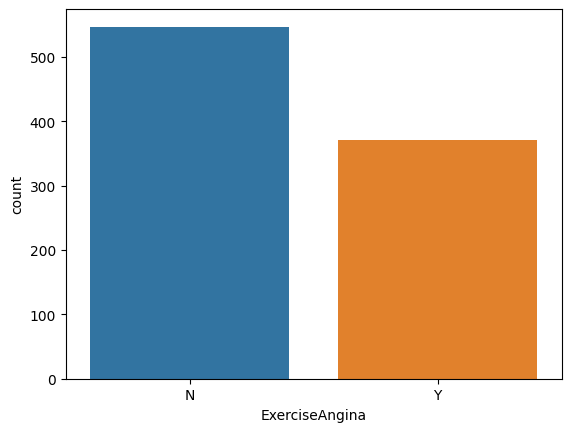

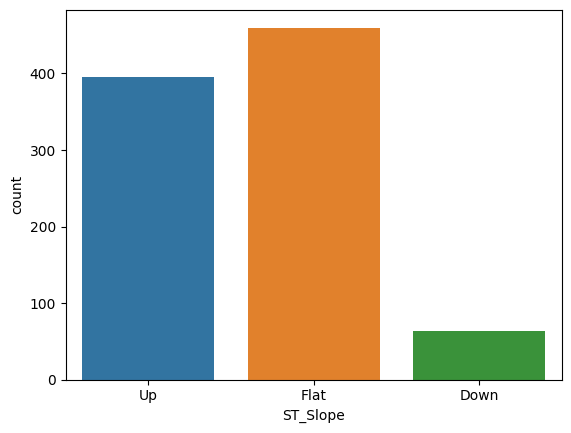

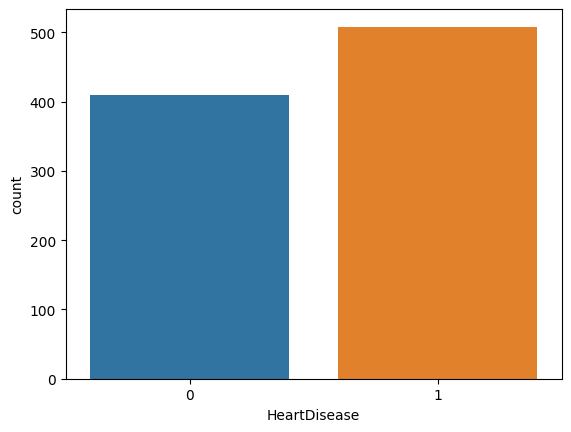

In [8]:
for column in cat_features:
    sns.countplot(x=column, data=data)
    plt.xticks()
    plt.show()

- Числовые

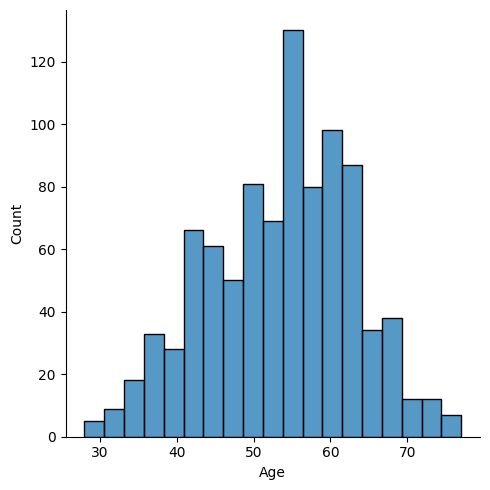

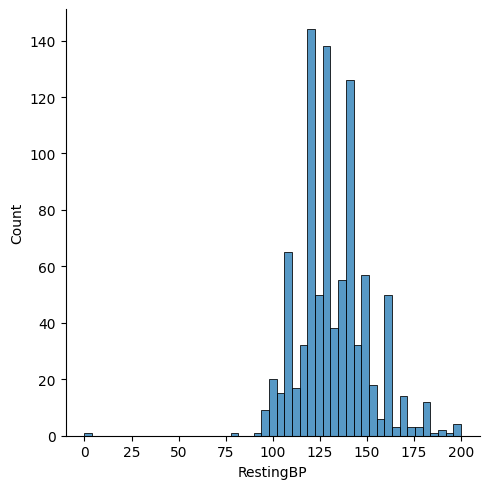

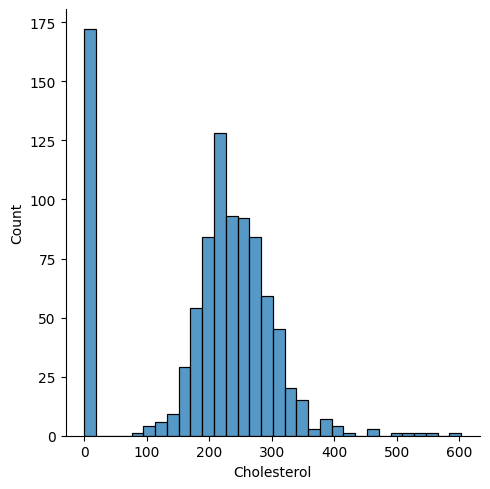

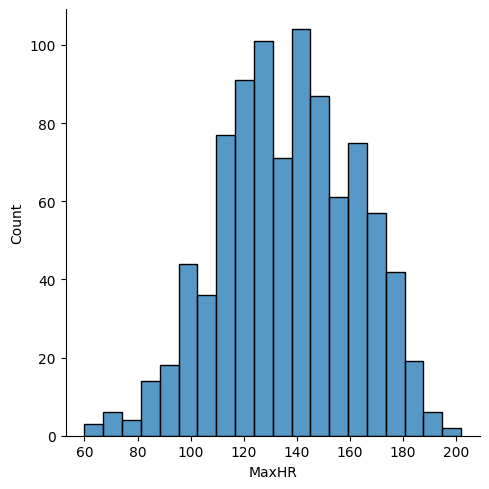

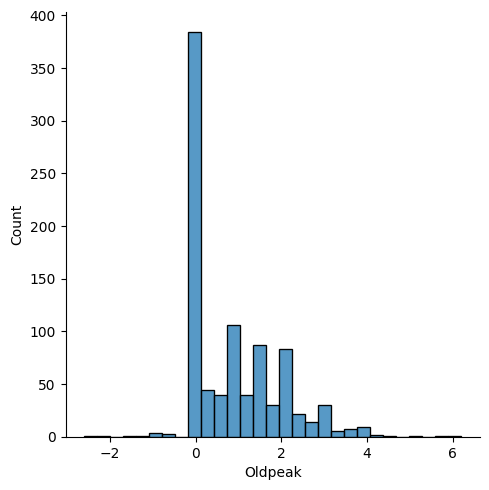

In [9]:
for column in num_features:
    sns.displot(x=column, data=data)
    plt.xticks()
    plt.show()

-------

#### Обработка данных

In [10]:
data_cat = dummy_encode(data, cat_features)

In [11]:
data_cat.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease_1
0,40,140,289,172,0.0,1,1,0,0,0,1,0,0,0,1,0
1,49,160,180,156,1.0,0,0,1,0,0,1,0,0,1,0,1
2,37,130,283,98,0.0,1,1,0,0,0,0,1,0,0,1,0
3,48,138,214,108,1.5,0,0,0,0,0,1,0,1,1,0,1
4,54,150,195,122,0.0,1,0,1,0,0,1,0,0,0,1,0


<Axes: >

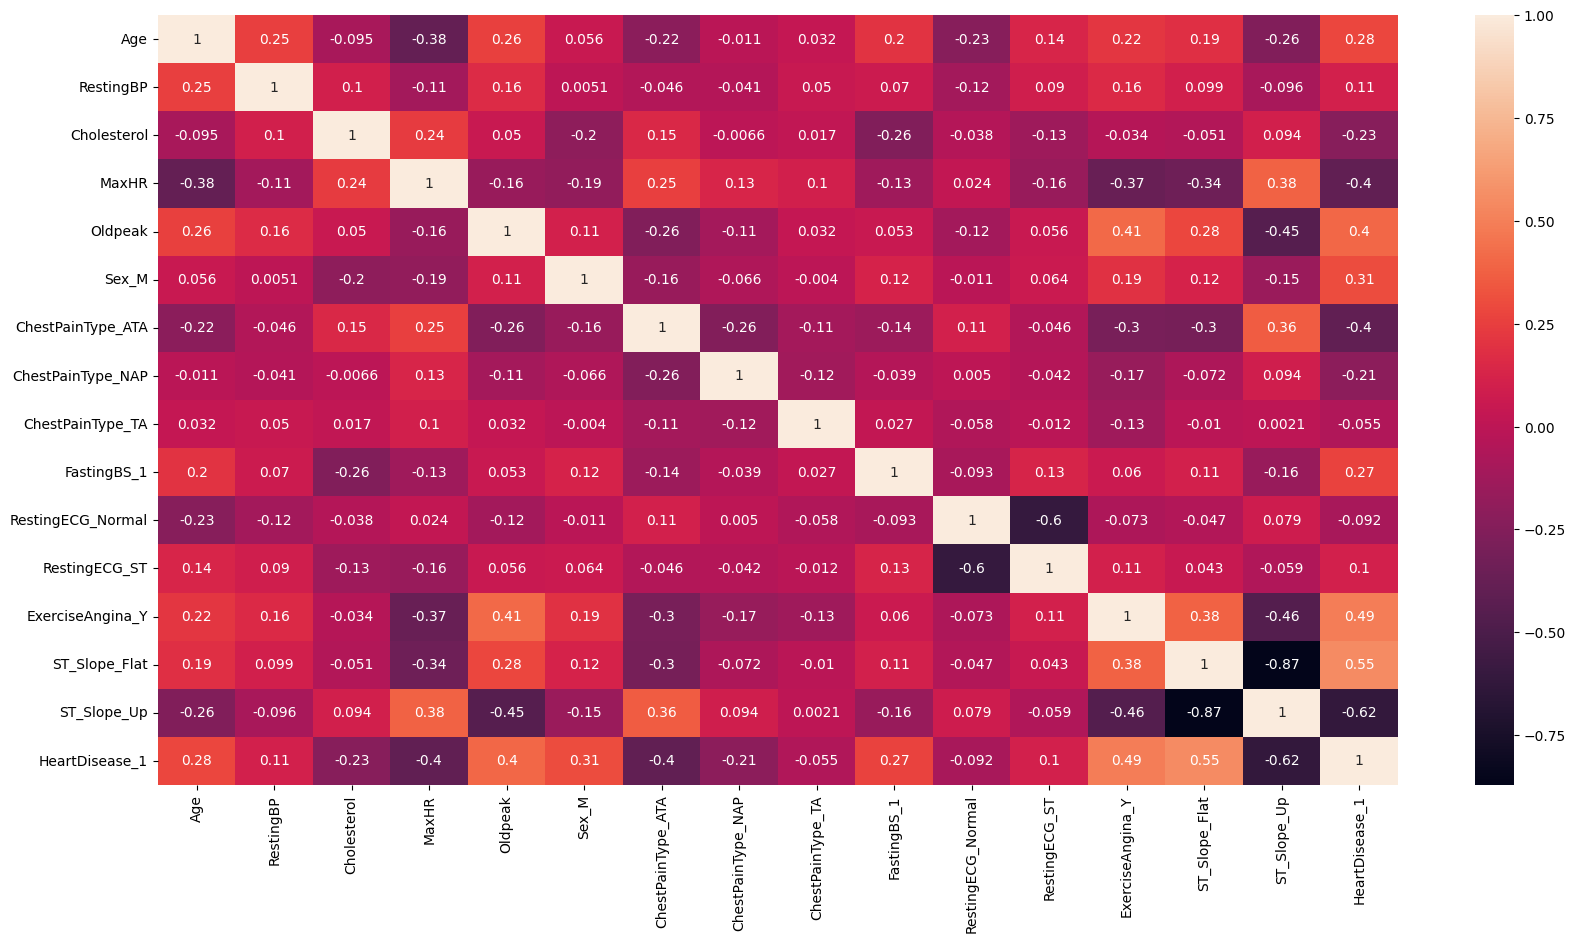

In [12]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_cat.corr(), annot=True)

--------

#### Моделируем

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [14]:
X = data_cat.drop('HeartDisease_1', axis=1)
y = data_cat['HeartDisease_1']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train, X_valid = standard_norm(X_train, X_valid, num_features)

##### LogisticRegression

In [16]:
logistic_reg = LogisticRegression(random_state=0, C=10, penalty='l2')

In [17]:
model(logistic_reg, X_train, X_valid, y_train, y_valid)

Accuracy: 0.8532608695652174
CV: 0.9240584286190454
ROC_AUC Score: 0.8556256827284863


              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



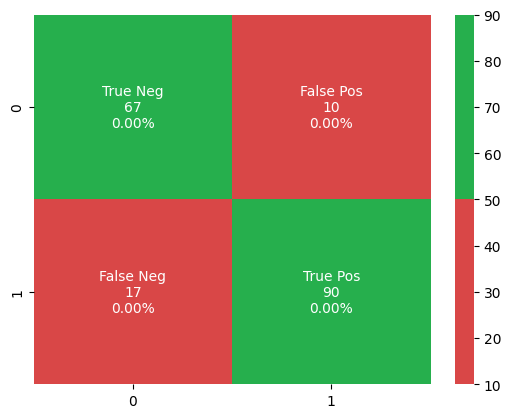

In [18]:
model_evaluation(logistic_reg, X_valid, y_valid)

##### RandomForest

In [19]:
rf_classifier = RandomForestClassifier(max_depth=4)

In [20]:
model(rf_classifier, X_train, X_valid, y_train, y_valid)

Accuracy: 0.8532608695652174
CV: 0.9219598966711592
ROC_AUC Score: 0.850163854836752


              precision    recall  f1-score   support

           0       0.82      0.83      0.83        77
           1       0.88      0.87      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



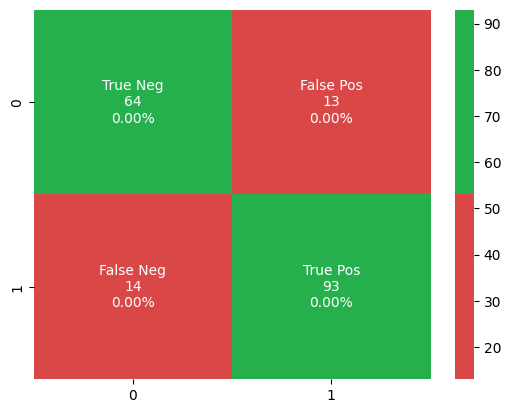

In [21]:
model_evaluation(rf_classifier, X_valid, y_valid)

##### CatBoost

In [22]:
cat_boost = CatBoostClassifier(verbose=0)

In [23]:
model(cat_boost, X_train, X_valid, y_train, y_valid)

Accuracy: 0.8695652173913043
CV: 0.9299527556772895
ROC_AUC Score: 0.8678237650200267


              precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



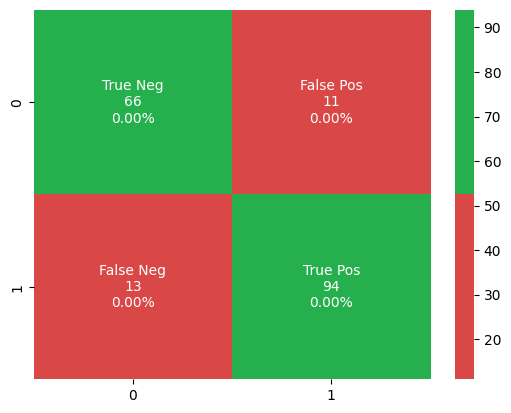

In [24]:
model_evaluation(cat_boost, X_valid, y_valid)

##### ExtremeGradientBoosting

In [25]:
xgb = XGBClassifier(verbosity=0)

In [26]:
model(xgb, X_train, X_valid, y_train, y_valid)

Accuracy: 0.8641304347826086
CV: 0.9168852803501296
ROC_AUC Score: 0.863150867823765


              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



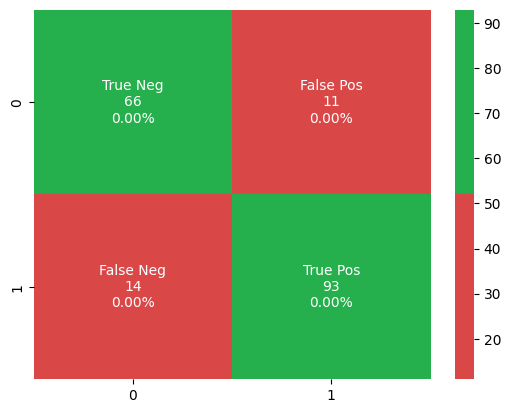

In [27]:
model_evaluation(xgb, X_valid, y_valid)

#### Гипертюнинг

In [28]:
def cat_objective(search_space):
    model = CatBoostClassifier(**search_space,
                               early_stopping_rounds=100,
                               verbose=False
                              )
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    return 1 - np.mean(score)


space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'iterations': hp.quniform('iterations', 100, 1500, 100),
    'depth': hp.quniform('depth', 1, 5, 1),
    'border_count': hp.quniform('border_count', 30, 220, 5), 
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

algorithm = tpe.suggest
trials = Trials()

In [29]:
best_params = fmin(
    fn=cat_objective,
    space=space,
    algo=algorithm,
    max_evals=50,
    trials=trials
)

100%|██████████| 50/50 [08:34<00:00, 10.29s/trial, best loss: 0.06994762908859053]


In [30]:
hyperparams = space_eval(space, best_params)
hyperparams

{'border_count': 145.0,
 'depth': 4.0,
 'iterations': 1000.0,
 'l2_leaf_reg': 9.0,
 'learning_rate': 0.01319178085522269}

In [31]:
params = {'border_count' : hyperparams['border_count'],
          'depth' : hyperparams['depth'],
          'iterations' : hyperparams['iterations'],
          'l2_leaf_reg' : hyperparams['l2_leaf_reg'],
          'early_stopping_rounds': 100,
          'learning_rate' : hyperparams['learning_rate']}

In [32]:
cat_boost = CatBoostClassifier(**params, random_seed=42)
cat_boost.fit(X=X_train, y=y_train, eval_set=(X_valid, y_valid),verbose=250)
train_preds = cat_boost.predict(X_train)
valid_preds = cat_boost.predict(X_valid)

0:	learn: 0.6860922	test: 0.6870163	best: 0.6870163 (0)	total: 514us	remaining: 514ms
250:	learn: 0.2904302	test: 0.3563858	best: 0.3563858 (250)	total: 109ms	remaining: 327ms
500:	learn: 0.2419708	test: 0.3391960	best: 0.3390984 (496)	total: 218ms	remaining: 217ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3362386488
bestIteration = 586

Shrink model to first 587 iterations.


In [33]:
def get_all_metrics(X, model, y_true):
    if X is X_train:
        print('Metrics for Train SAMPLE', 'red', end='\n\n')
    else:
        print('Metrics for Valid SAMPLE', 'red', end='\n\n')
    y_pred = model.predict(X)
    y_score = model.predict_proba(X)[:, 1]
    metrics = {
        'roc_auc_score': round(roc_auc_score(y_true, y_score), 3),
        'accuracy_score': round(accuracy_score(y_true, y_pred), 3)
    }
    
    return metrics

In [34]:
# Train
get_all_metrics(X_train, cat_boost, y_train)

Metrics for Train SAMPLE red



{'roc_auc_score': 0.974, 'accuracy_score': 0.918}

In [35]:
# Valid
get_all_metrics(X_valid, cat_boost, y_valid)

Metrics for Valid SAMPLE red



{'roc_auc_score': 0.934, 'accuracy_score': 0.87}

In [36]:
cat_boost.save_model('/home/nfrvnikita/miocard/models/catboost_model')

In [50]:
data['ExerciseAngina'].unique()

array(['N', 'Y'], dtype=object)

In [52]:
data['HeartDisease'].unique()

array([0, 1])